In [1]:
!mkdir norm_data

mkdir: cannot create directory ‘norm_data’: File exists


In [45]:
import xarray as xr
from tabnet.cols import *

In [46]:
from netCDF4 import Dataset

data_dir = './'
wrf_filename = '%evaluation.nc' % data_dir

ncf = Dataset(wrf_filename, "r", format="NETCDF4")

ncf.variables['Z']

<class 'netCDF4._netCDF4.Variable'>
float32 Z(Time, bottom_top, south_north, west_east)
    FieldType: 104
    MemoryOrder: XYZ
    description: 
    units: 
    stagger: 
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (133, 39, 159, 169)
filling on, default _FillValue of 9.969209968386869e+36 used

In [47]:
import numpy as np
means, stds, mins = [],[],[]
for f in feat_cols:
    print(f)
    if f in ["Z", "XLONG", "XLAT"]:
        d = ncf.variables[f][:]
        
        mean = d.data.mean()
        std  = d.data.std()
        _min = 0
        
    elif f == "P":
        d = np.log(ncf.variables[f][:] + ncf.variables["PB"][:])
        mean = d.data.mean()
        std  = d.data.std()
        _min = d.data.min()
    else:
        d = ncf.variables[f][:]
        _min = d[d>0].data.min()
        d = np.log(d[d>0])        
        mean = d.data.mean()
        std  = d.data.std()
    if np.isnan(mean):
        raise ValueError
        break
    print(mean, std,_min)
    means.append(mean)
    stds.append(std)
    mins.append(_min)

TOT_NUM_CONC
18.34305 0.70758617 16268106.0
TOT_MASS_CONC
-22.136595 1.1218609 1.7770521e-11
pmc_SO4
-22.968529 0.9752101 8.903093e-12
pmc_NO3
-34.056034 3.4018872 2.192536e-36
pmc_Cl
-67.15881 11.093026 9.742914e-37
pmc_NH4
-35.829586 10.300515 8.40248e-28
pmc_ARO1
-48.09038 12.844878 1.8262328e-29
pmc_ARO2
-50.21829 11.358317 1.8257875e-29
pmc_ALK1
-43.37317 12.804973 1.8379988e-29
pmc_OLE1
-47.83909 13.497766 1.7628426e-29
pmc_API1
-25.16306 0.6907709 1.4712568e-12
pmc_API2
-58.478157 1.658301 2.0275822e-29
pmc_LIM1
-58.055008 2.0760894 2.1161772e-29
pmc_LIM2
-58.221355 1.8911927 2.1159639e-29
pmc_OC
-24.806288 1.0137749 9.668668e-13
pmc_BC
-25.524881 0.99945027 4.8321704e-13
pmc_H2O
-23.364775 1.3750651 2.0708806e-31
TEMPERATURE
5.5034914 0.118394464 204.89928
REL_HUMID
-1.5752105 0.7056577 0.1
ALT
0.84901726 0.8125616 0.8095495
Z
8953.694 6434.8677 0
XLAT
37.996223 1.6670182 0
XLONG
-121.46553 2.2313697 0
h2so4
-12.644124 4.791286 1e-16
hno3
-1.6351258 1.3629346 0.00053429307
hcl


In [38]:
import numpy as np
tmeans, tstds, tmins = [],[],[]
for f in target_cols:
    print(f)
    if f in ["Z", "XLONG" ]:
        d = ncf.variables[f][:]
        
        mean = d.data.mean()
        std  = d.data.std()
        _min = 0
        
    elif f == "P":
        d = np.log(ncf.variables[f][:] + ncf.variables["PB"][:])
        mean = d.data.mean()
        std  = d.data.std()
        _min = d.data.min()
    else:
        d = ncf.variables[f][:]
        _min = d[d>0].data.min()
        d = np.log(d[d>0])        
        mean = d.data.mean()
        std  = d.data.std()
    if np.isnan(mean):
        raise ValueError
        break
    print(mean, std,_min)
    tmeans.append(mean)
    tstds.append(std)
    tmins.append(_min)

ccn_001
15.125228 1.3428156 428.79596
ccn_003
16.548517 1.0779657 1046069.94
ccn_006
16.995298 1.0479535 1982495.5
CHI
-0.34824014 0.08097392 0.26412672
CHI_CCN
-0.3262838 0.10943509 0.091962054
D_ALPHA
0.73368394 0.20763765 1.1088711
D_GAMMA
0.92895013 0.2632665 1.1616677
D_ALPHA_CCN
0.346326 0.07147439 1.0443573
D_GAMMA_CCN
0.45309588 0.091097355 1.0637652
PM25
-22.556446 1.1029556 1.1534183e-11


In [39]:
logmean = [m.item() for m in tmeans]
logstd = [m.item() for m in tstds]
logmin = [m for m in tmins]

In [42]:
for i in range(133):
    tmps = []
    for fidx, f in enumerate(target_cols):
        
        if f in ["Z", "XLONG" ]:            
            tmp = ((ncf.variables[f][i,:] - logmean[fidx]) / logstd[fidx]).data #.flatten()
    
        elif f == "P":
            d = np.log(ncf.variables[f][i,:] +ncf.variables["PB"][i,:])
            tmp = ((d - logmean[fidx]) / logstd[fidx]).data #.flatten()
        else:
            d = ncf.variables[f][i,:].data #.flatten()
            
            d[d==0] = logmin[fidx]
            tmp = (np.log(d) - logmean[fidx]) / logstd[fidx]
        if f in ['XLONG', 'XLAT']:
            tmp = np.repeat(tmp[np.newaxis,...],39,axis=0)
        tmps.append(tmp.flatten())
#     tmps.append(np.ones_like(ncf.variables[f][i,:].data.flatten())* time_embed[i])
    np.save(f'norm_data/t{i}_targ.npy', np.vstack(tmps).transpose())

In [34]:
len(logmin)

102

In [78]:
# for i in range(133):
#     tmp = []
#     for f in feat_cols:
#         tmp.append(ds_training[f][i,...].data.flatten())
#     tmp.append(np.ones_like(ds_training[f][i,...].data.flatten())* time_embed[i])
#     np.save(f'time_embed_data/t{i}_feat.npy', np.vstack(tmp).transpose())

In [79]:
# ds_training['pmc_NO3']

In [12]:
ds_training = xr.open_dataset("training.nc")
# time_axis = ["".join( ds_training['Times'][i].data.astype(str))[-8:] for i in range(133)]

time_axis = [t[-8:] for t in ds_training['Times'].data.astype(str)]
hrs  = [float(time_axis[i].split(":")[0]) for i in range(len(time_axis))]
mins_in_hrs = [float(time_axis[i].split(":")[1])/60 for i in range(len(time_axis))]

timestamp_hrs = np.array([(h+m)/24 for h,m in zip(hrs, mins_in_hrs)])
time_embed = np.cos(timestamp_hrs*np.pi*2)

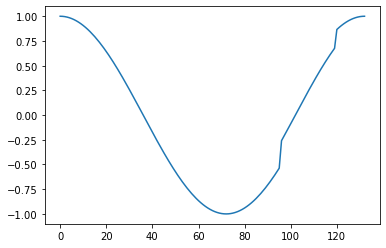

In [14]:
import matplotlib.pyplot as plt
plt.plot(time_embed)

In [23]:
for i in range(133):
    tmps = []
    for fidx, f in enumerate(feat_cols):
        
        if f in ["Z", "XLONG" ]:            
            tmp = ((ncf.variables[f][i,:] - logmean[fidx]) / logstd[fidx]).data #.flatten()
    
        elif f == "P":
            d = np.log(ncf.variables[f][i,:] +ncf.variables["PB"][i,:])
            tmp = ((d - logmean[fidx]) / logstd[fidx]).data #.flatten()
        else:
            d = ncf.variables[f][i,:].data #.flatten()
            
            d[d==0] = logmin[fidx]
            tmp = (np.log(d) - logmean[fidx]) / logstd[fidx]
        if f in ['XLONG', 'XLAT']:
            tmp = np.repeat(tmp[np.newaxis,...],39,axis=0)
        tmps.append(tmp.flatten())
    tmps.append(np.ones_like(ncf.variables[f][i,:].data.flatten())* time_embed[i])
    np.save(f'norm_data/t{i}_feat.npy', np.vstack(tmps).transpose())

TOT_NUM_CONC 0 <class 'numpy.ndarray'> (39, 159, 169)
TOT_MASS_CONC 1 <class 'numpy.ndarray'> (39, 159, 169)
pmc_SO4 2 <class 'numpy.ndarray'> (39, 159, 169)
pmc_NO3 3 <class 'numpy.ndarray'> (39, 159, 169)
pmc_Cl 4 <class 'numpy.ndarray'> (39, 159, 169)
pmc_NH4 5 <class 'numpy.ndarray'> (39, 159, 169)
pmc_ARO1 6 <class 'numpy.ndarray'> (39, 159, 169)
pmc_ARO2 7 <class 'numpy.ndarray'> (39, 159, 169)
pmc_ALK1 8 <class 'numpy.ndarray'> (39, 159, 169)
pmc_OLE1 9 <class 'numpy.ndarray'> (39, 159, 169)
pmc_API1 10 <class 'numpy.ndarray'> (39, 159, 169)
pmc_API2 11 <class 'numpy.ndarray'> (39, 159, 169)
pmc_LIM1 12 <class 'numpy.ndarray'> (39, 159, 169)
pmc_LIM2 13 <class 'numpy.ndarray'> (39, 159, 169)
pmc_OC 14 <class 'numpy.ndarray'> (39, 159, 169)
pmc_BC 15 <class 'numpy.ndarray'> (39, 159, 169)
pmc_H2O 16 <class 'numpy.ndarray'> (39, 159, 169)
TEMPERATURE 17 <class 'numpy.ndarray'> (39, 159, 169)
REL_HUMID 18 <class 'numpy.ndarray'> (39, 159, 169)
ALT 19 <class 'numpy.ndarray'> (39, 15

In [16]:
i = 0
a = np.load(f'norm_data/t{i}_feat.npy')

In [37]:
logmean

[18.343050003051758,
 -22.136594772338867,
 -22.968528747558594,
 -34.056034088134766,
 -67.1588134765625,
 -35.829586029052734,
 -48.09038162231445,
 -50.21828842163086,
 -43.3731689453125,
 -47.839088439941406,
 -25.16305923461914,
 -58.47815704345703,
 -58.05500793457031,
 -58.22135543823242,
 -24.80628776550293,
 -25.52488136291504,
 -23.364774703979492,
 5.503491401672363,
 -1.575210452079773,
 0.8490172624588013,
 8953.6943359375,
 3.636521339416504,
 -121.46553039550781,
 -12.644124031066895,
 -1.635125756263733,
 -30.564319610595703,
 -15.93230152130127,
 -9.1224946975708,
 -2.663417339324951,
 -10.18704891204834,
 -7.158599853515625,
 -10.355517387390137,
 -5.195564270019531,
 4.758638381958008,
 -34.33604049682617,
 -23.739253997802734,
 -11.831676483154297,
 -7.7264909744262695,
 -1.4953625202178955,
 4.210816383361816,
 -6.44951868057251,
 -26.51392364501953,
 -26.126344680786133,
 -15.172676086425781,
 -27.74088478088379,
 -3.591775417327881,
 -17.045839309692383,
 -27.667

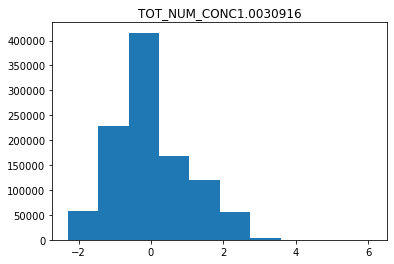

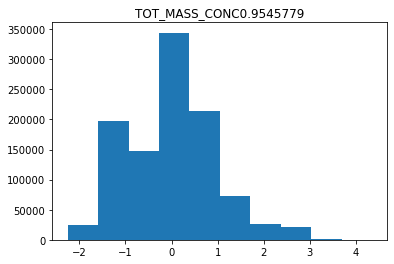

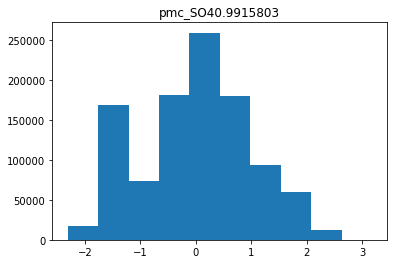

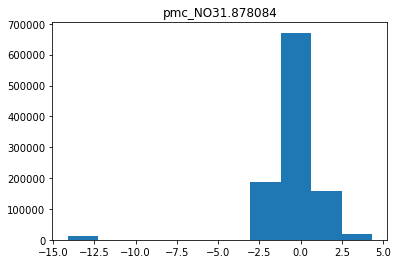

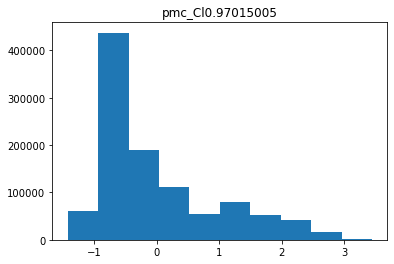

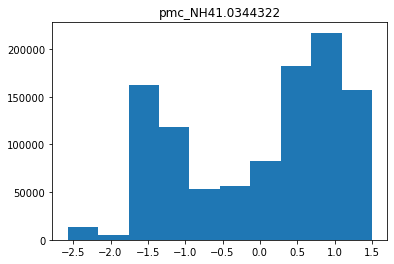

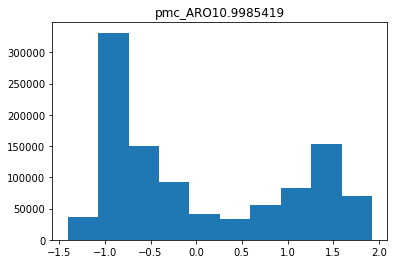

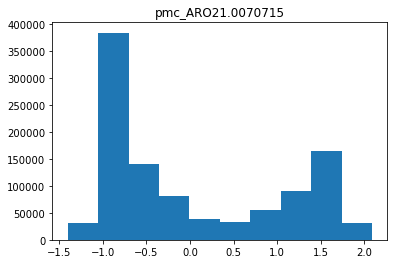

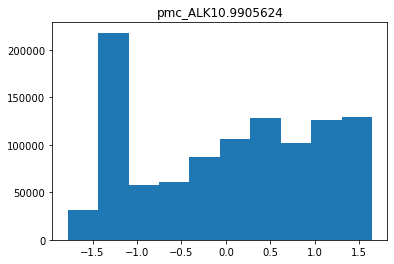

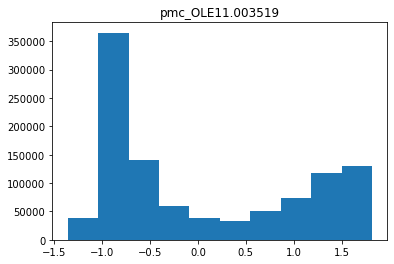

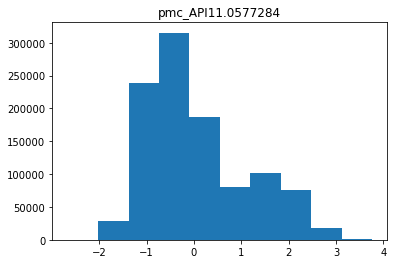

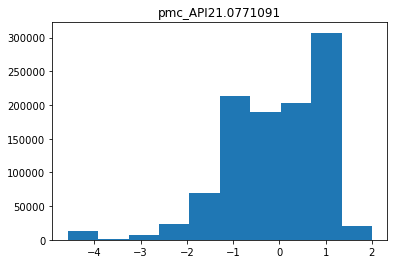

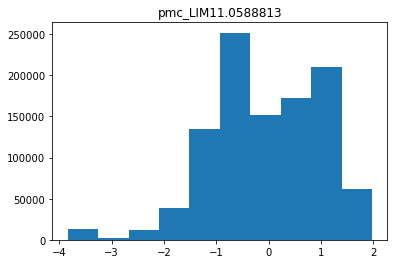

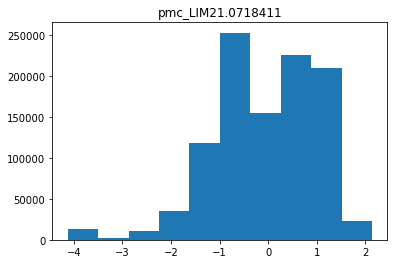

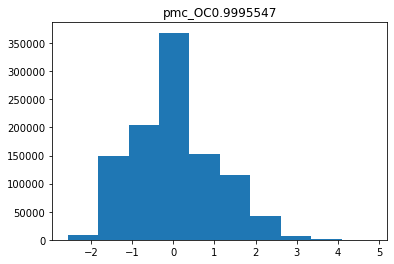

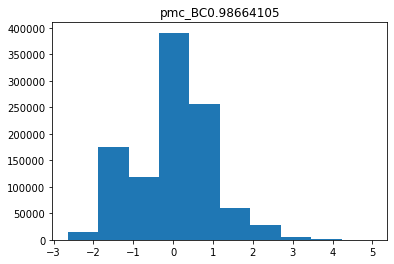

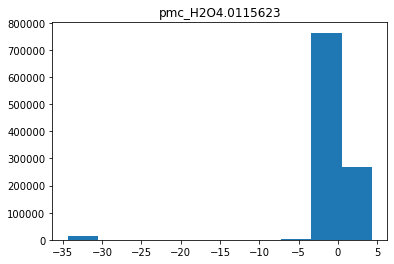

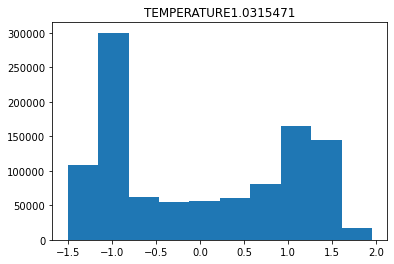

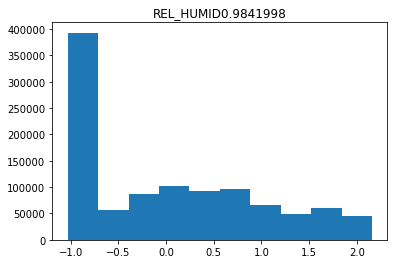

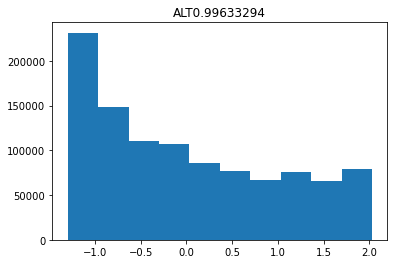

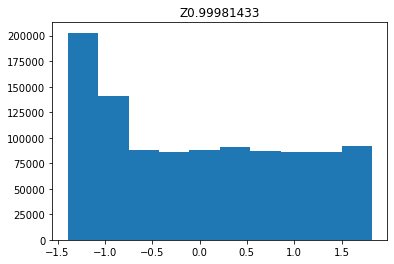

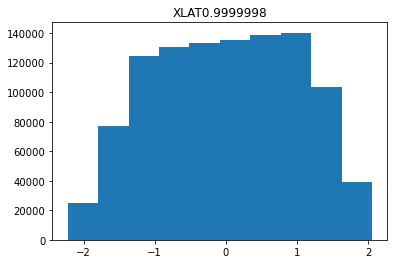

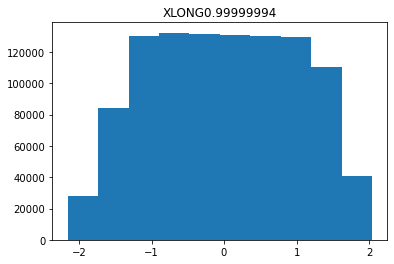

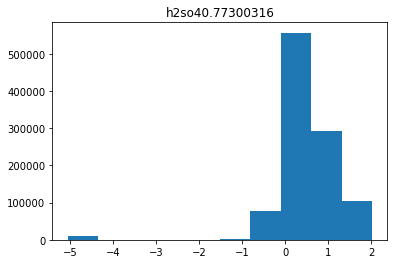

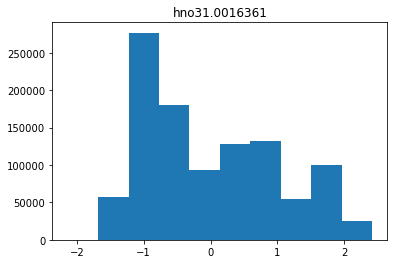

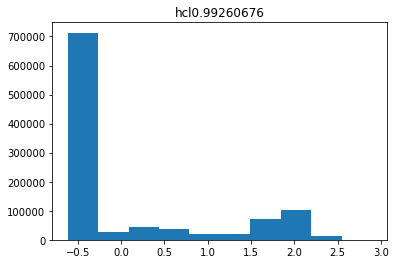

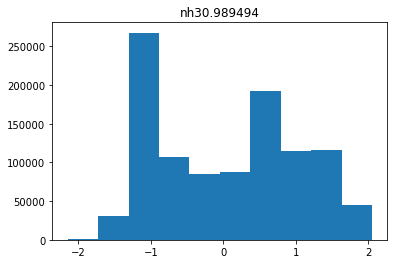

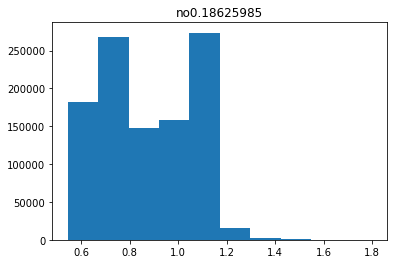

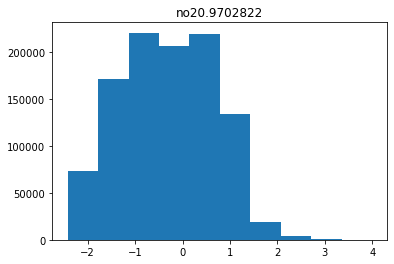

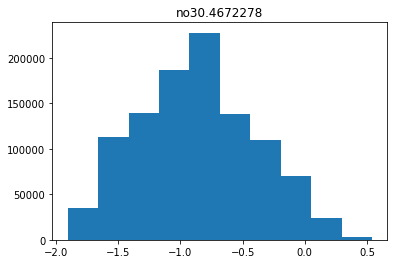

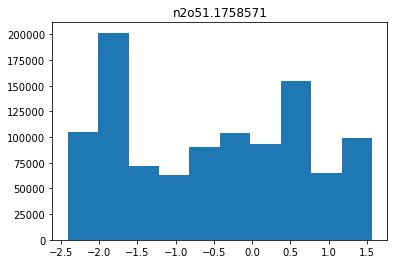

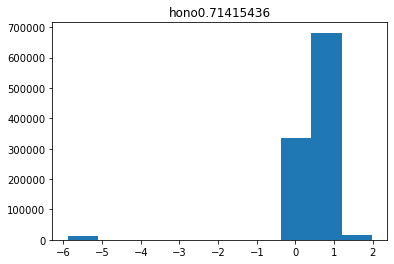

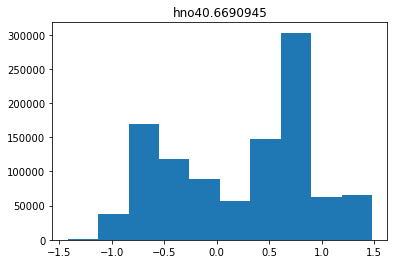

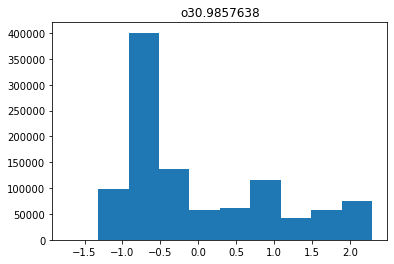

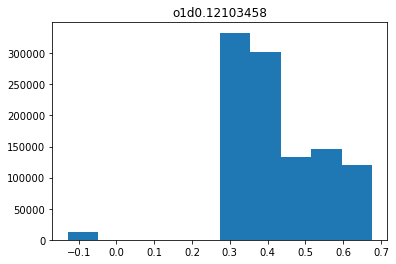

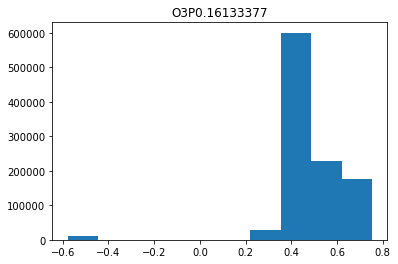

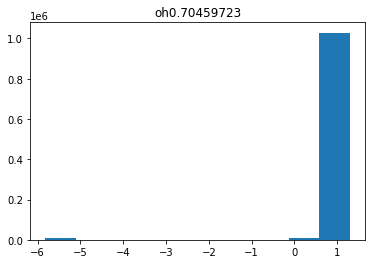

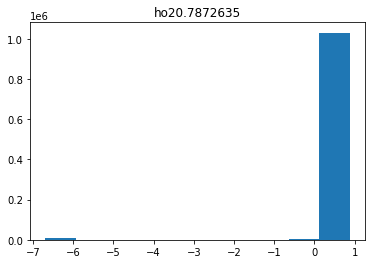

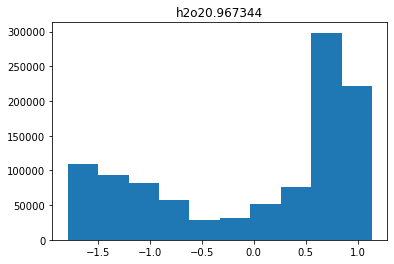

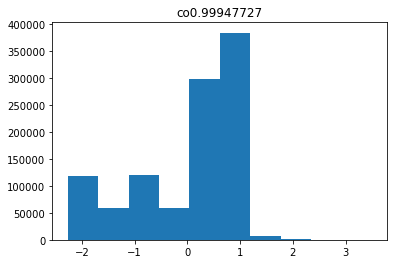

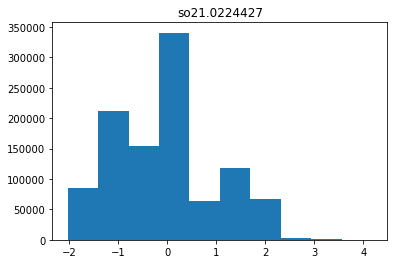

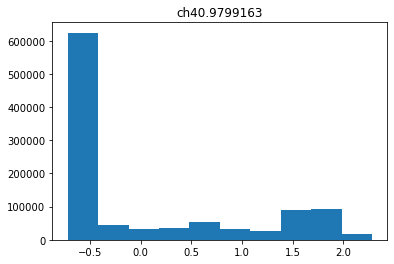

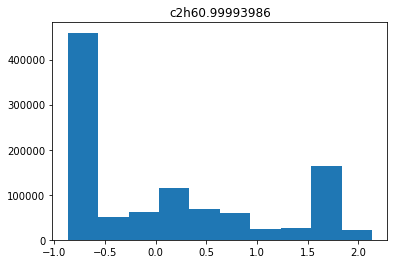

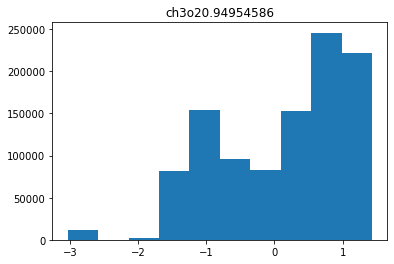

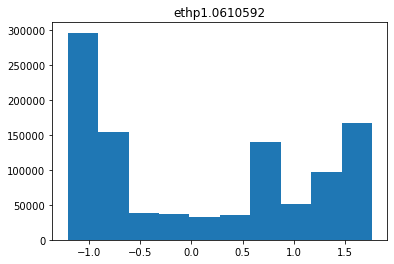

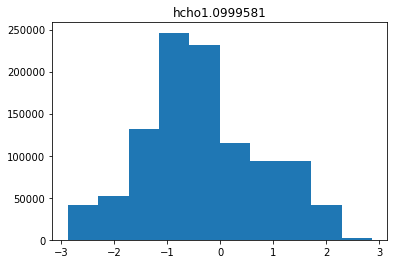

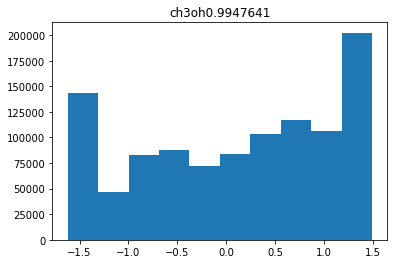

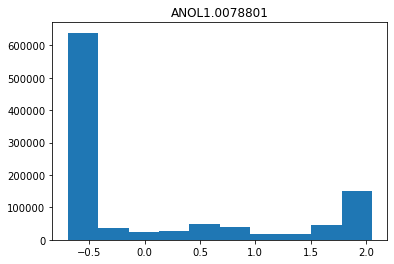

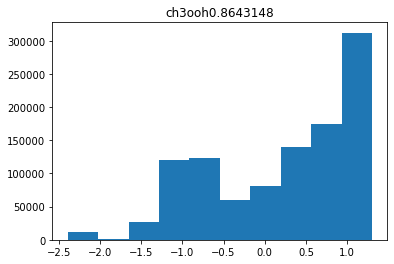

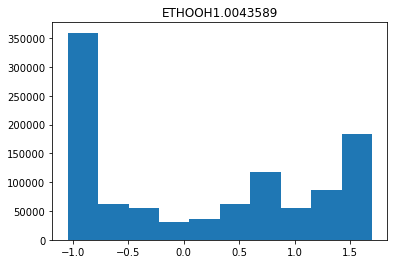

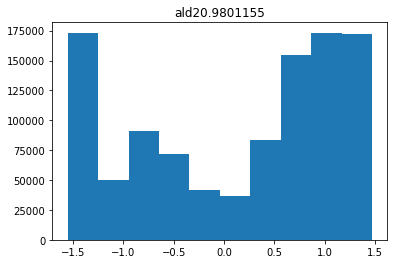

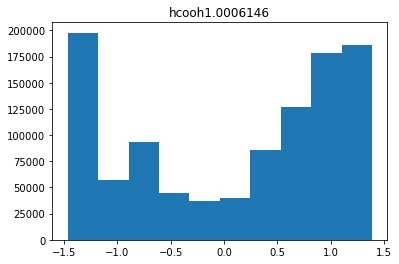

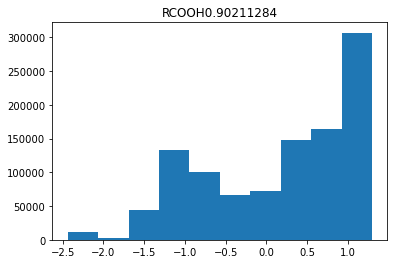

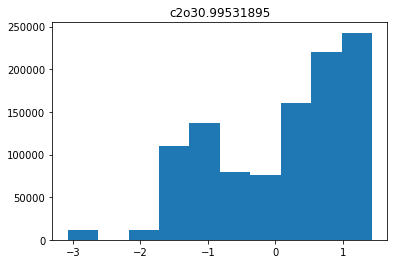

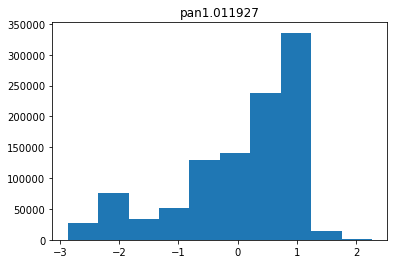

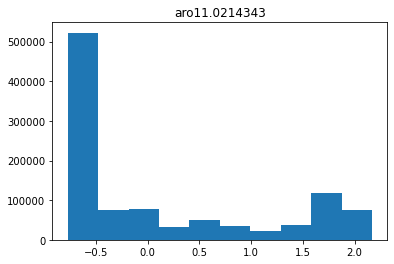

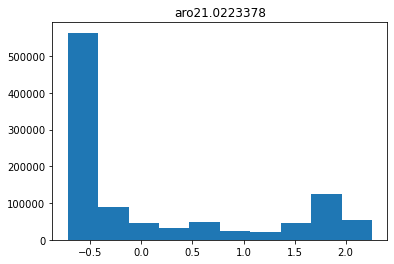

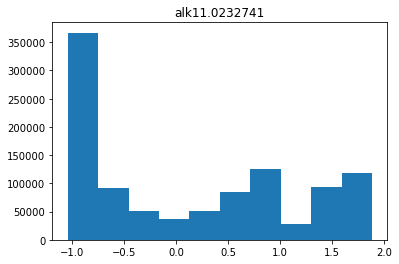

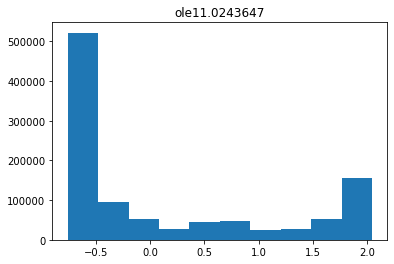

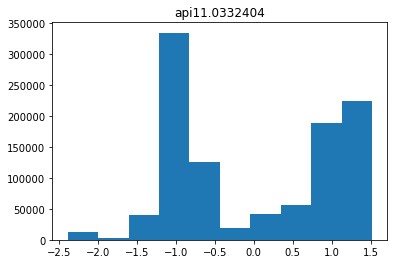

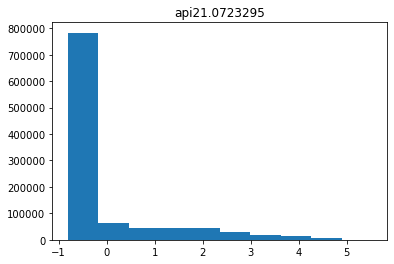

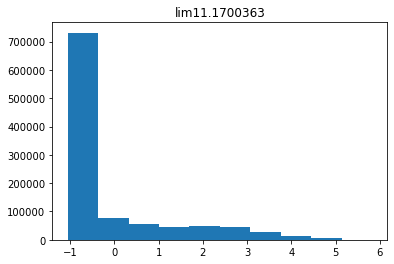

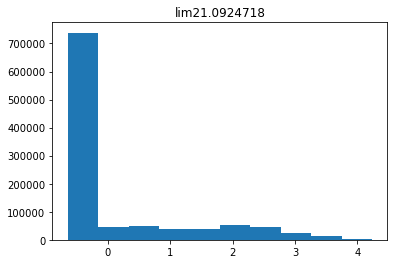

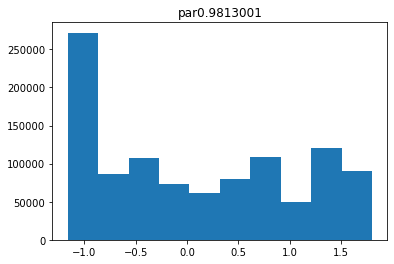

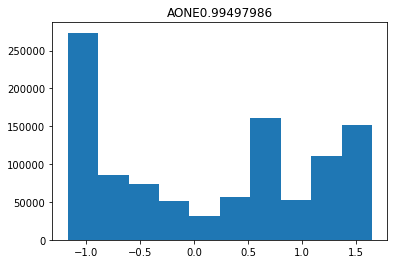

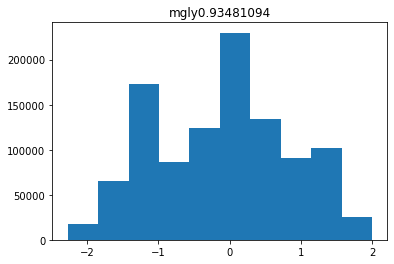

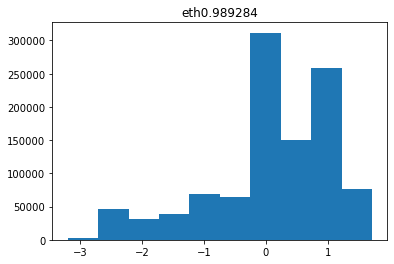

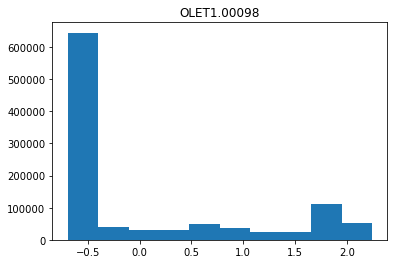

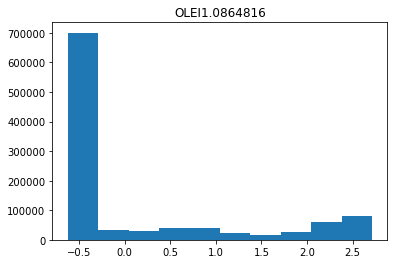

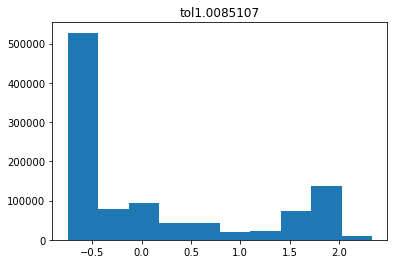

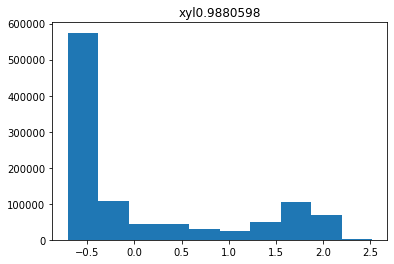

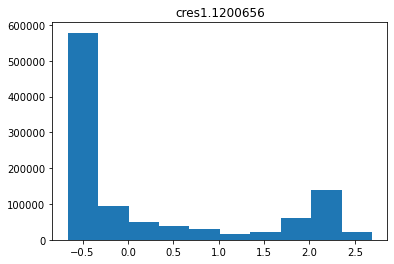

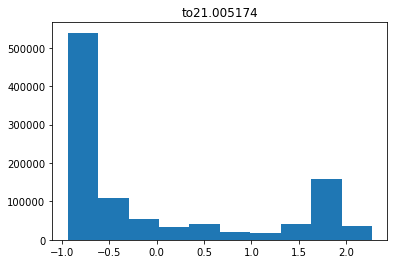

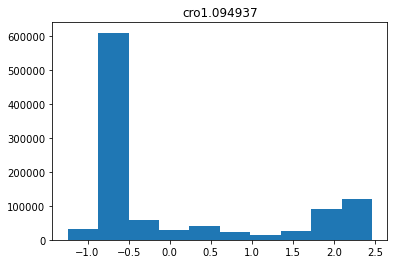

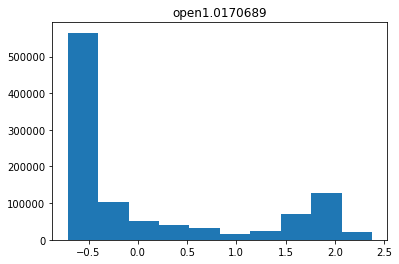

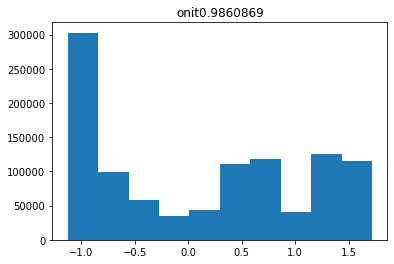

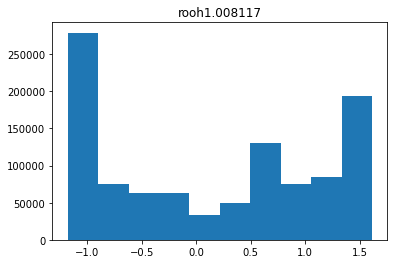

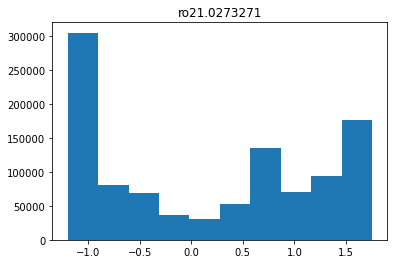

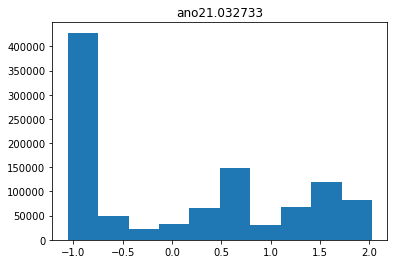

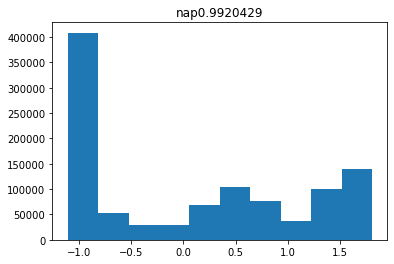

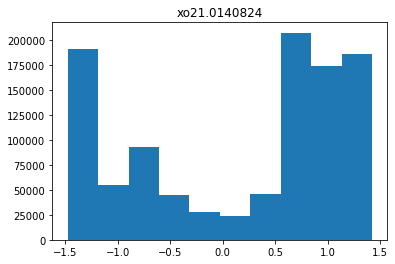

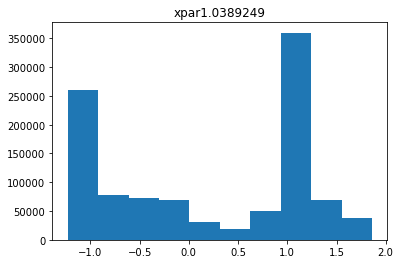

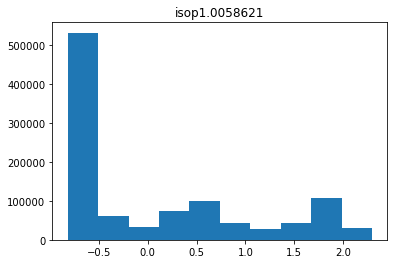

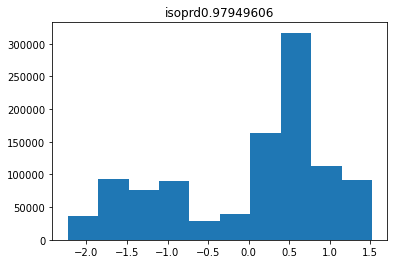

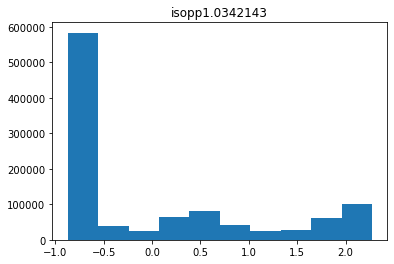

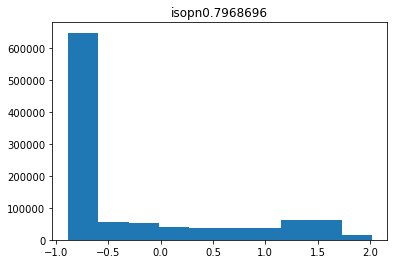

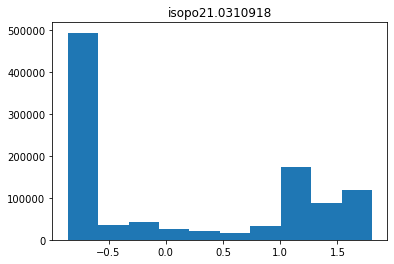

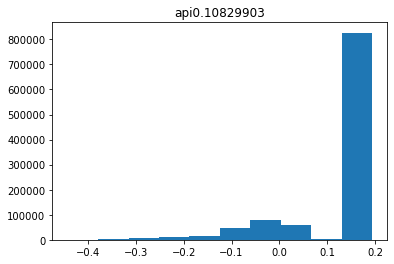

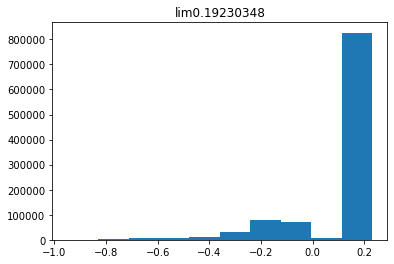

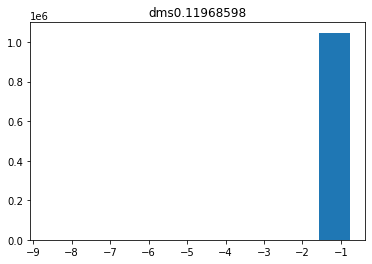

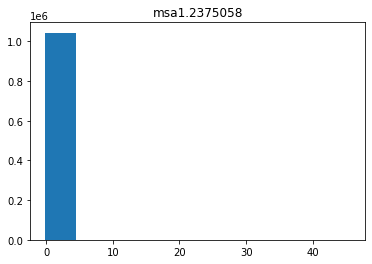

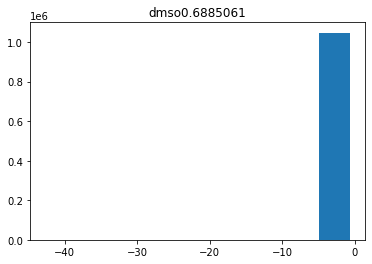

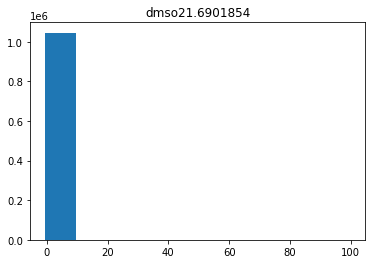

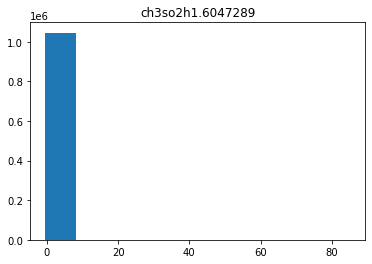

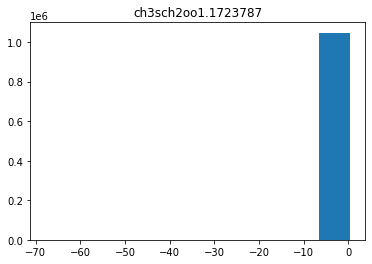

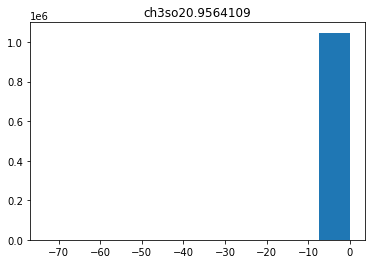

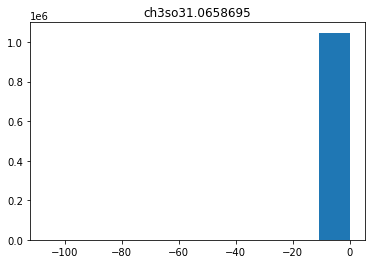

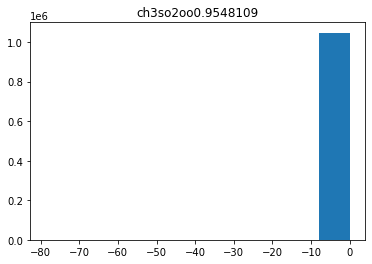

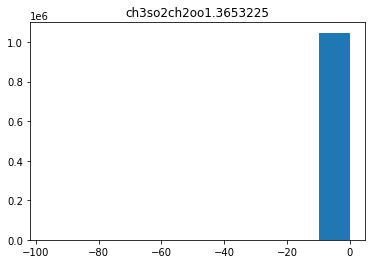

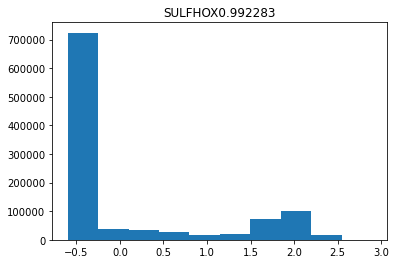

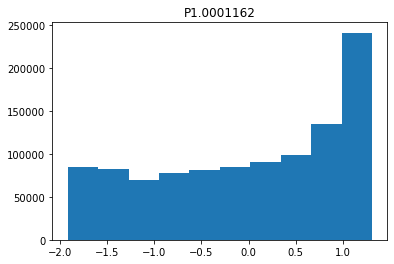

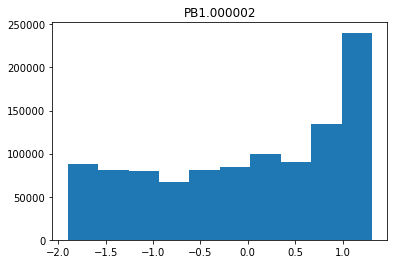

IndexError: list index out of range

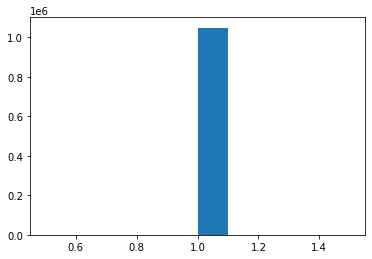

In [21]:
for idx in range(103):
    plt.hist(a[:,idx])
    plt.title(feat_cols[idx] + str(a[:,idx].std()))
    plt.show()

In [41]:
len(target_cols)

10

In [65]:
a[:,100].std()

0.23594807